## MBSE2KG: Notebook Recommending Possible Elements for a New Mission
### Notebook for querying Knowledge Graph (KG) of Enginnering Models (EM) for similar components

#### Summary
##### The comparison is based on comparing different metadata information (e.g. 'description') for a selection of past missions with the information for a new one and clustering these missions based on the semantic similarity between their metadata. Subsequently, a database of ECSS-E-TM-10-25A Engineering models (EMs) is queried for similar components in that cluster of missions. The similarity between components was established in two ways. Firstly, parameterstypes of each element were extracted and then compared with the parameters of other elements. The used similarity measure is the Jaccard index and referred in the notebook just as Jaccard. Secondly, the names of the elements were compared to each other. This was done by encoding the name with a neural language model (Sentence-BERT) and then calculating the cosine similarity of respective encodings. In the notebook, this similarity measure is referred to as "cosine". 


<img src="Recommendation_engine.drawio.png" width="600" height="480" style="margin:auto"/>
<em>Fig 1. Flowchart for recommendation</em>

#### Outputs
##### The results are returned for every metadata that is not empty from a dictionary of possible metadata entries. In addition, a weighted average is calculated between each respective metadata similarity. The outcome of this comparison is also returned. Specific metadata can be excluded from the detailed comparison as well. The results of the element comparison are prepared in two ways. One of them is using triadic closure to establish "groups" of similiar elements. The process is based on the assumption that if one element has a high similarity to two separate elements, than these two elements should also share similarity. The other output is a detailed list of all elements that were deemed to be similar between two missions in a cluster. 

<img src="Triadic_closure.drawio.png" width="720" height="600" style="margin:auto"/>
<em>Fig 2. Triadic closure</em>


## Define all neccesary functions for comparison 

### expand cells by clicking on them, expand again by clicking on blue bar on the side of cell 

In [24]:
from typedb.client import *
import json

import numpy as np
import pandas as pd
from pandas import ExcelWriter

from sklearn.manifold import MDS
import matplotlib.pyplot as plt

import itertools
from itertools import cycle

from sklearn.cluster import AffinityPropagation
import random 

from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer('all-mpnet-base-v2')

def get_data(labels,server_address):
    
    """
    Getting Metadata information and similarities from KG for a list of labels (metadatas)
    :param labels: list e.g. ['description', 'lagrangePoint'] 
    
    """
    
    metadatas = {}
    sims = []
    
    with TypeDB.core_client(server_address) as client:
        with client.session(db_name, SessionType.DATA) as session:
            for label in labels:
                typeql_match_query = f'''match $ed1 isa ElementDefinition, has shortName $mission1;  #has name $mission1;
                                    $ed2 isa ElementDefinition, has shortName $mission2;  #has name $mission2;
                                    $meta1 isa ParameterGroup, has name "Metadata";
                                    $meta2 isa ParameterGroup, has name "Metadata";

                                    $metacontain1(contains:$ed1,isContained: $meta1) isa Containment_parameterGroup;
                                    $metacontain2(contains:$ed2,isContained: $meta2) isa Containment_parameterGroup;
                                    $parameter1 isa Parameter, has s_bert_embedding $embed1;
                                    $parameter2 isa Parameter, has s_bert_embedding $embed2;
                                    $parameter_con1(refersTo:$parameter1,isReferredBy:$meta1) isa Reference_group;
                                    $parameter_con2(refersTo:$parameter2,isReferredBy:$meta2) isa Reference_group;

                                    $parametervalueSet1 isa ParameterValueSet, has published $value1;
                                    $parametervalueSet2 isa ParameterValueSet, has published $value2;
                                    $valSet1(contains:$parameter1, isContained:$parametervalueSet1) isa Containment_valueSet;
                                    $valSet2(contains:$parameter2, isContained:$parametervalueSet2) isa Containment_valueSet;
                                    $similarity_par(refersTo:$parameter1, isReferredBy:$parameter2) isa Reference_SimilarityFactor, has metadataLabel "{label}", has simFactor $sim;
                                    get $mission1, $mission2,$embed1, $embed2, $value1, $value2, $similarity_par, $sim; 
                                    '''
                with session.transaction(TransactionType.READ) as read_transaction:

                    iterator = read_transaction.query().match(typeql_match_query)

                    answers = [ans for ans in iterator]

                    mission1 = [ans.get('mission1').get_value() for ans in answers]
                    mission2 = [ans.get('mission2').get_value() for ans in answers]
                    embed1 = [json.loads(ans.get('embed1').get_value()) for ans in answers]
                    embed2 = [json.loads(ans.get('embed2').get_value()) for ans in answers]
                    values1 = [ans.get('value1').get_value() for ans in answers]
                    values2 = [ans.get('value2').get_value() for ans in answers]
                    simiid = [ans.get('similarity_par').get_iid() for ans in answers]
                    simvalues = [ans.get('sim').get_value() for ans in answers]

                for mis1,mis2,simval in zip(mission1,mission2,simvalues):
                    b = False
                    for sim in sims: 
                        if sim['models'] == (mis1, mis2):
                            sim[label]= simval
                            b = True
                    if b == False:
                        sims.append({'models':(mis1, mis2), label: simval}) 


                for mis, emb, val in zip(mission1+mission2,embed1+embed2,values1+values2):


                    metadatas[mis] = dict(metadatas.get(mis)or {}, **{label:{'encoding':emb, 'value':val}})
                                           
    missions = list(metadatas.keys())
    
    ## making sure similarities are sorted according to how they appear in "metadatas"
    indexes = [{'models':(missions.index(sim['models'][0]), missions.index(sim['models'][1])),'index':index} for index,sim in enumerate(sims)]
    indexes = sorted(indexes, key = lambda index: (index['models'][0], index['models'][1]))

    indexes = [index['index'] for index in indexes]
    sims_sort = [sims[i] for i in indexes]

    return metadatas, sims_sort


def dis_sim_matrix(sim_values, missions):
    """
    Creates a matrix of distance (dissimilarity) for a list of similarity values and associated missions
    Is used later for clustering
    :param sim_values: list e.g. [0.91, 0.14,...] 
    :param missions: list e.g. ['ARIEL', 'ATHENA', ...]
    """
    
    simma = np.zeros((len(missions),len(missions)))
    row = 0
    values_counter= -1
    while row <= simma.shape[0]:
        counter = 0
        while counter < (simma.shape[1]):
            if counter == row: 
                simma[counter,row]=0#1
                counter+=1
            elif counter>row:
                values_counter +=1
                simma[row,counter] = 1-sim_values[values_counter]
                simma[counter, row] = 1-sim_values[values_counter]
                counter+=1
            else:
                counter+=1
        row+=1 
    #display(pd.DataFrame(simma, columns = missions, index = missions).round(3))
    return simma 



def plot_affinity_propagation(X, missions, title):
    
    """
    Creates affinity propagation and plots the results for comparison data (X) and associated missions for specific metadata 
    :param X: numpy.array (2,n) e.g. [[0,1], [1,2],[...,...]]
    :param missions: list e.g. ['ARIEL', 'ATHENA', ...]
    :param title: string e.g. ['description']
    """
    
    
    af = AffinityPropagation( random_state=0).fit(X)
    cluster_centers_indices = af.cluster_centers_indices_
    labels = af.labels_
    n_clusters_ = len(cluster_centers_indices)

    plt.figure(figsize=(10, 10))

    colors = cycle("bgrcmykbgrcmykbgrcmykbgrcmyk")
    for k, col in zip(range(n_clusters_), colors):
        class_members = labels == k
        cluster_center = X[cluster_centers_indices[k]]
        plt.plot(X[class_members, 0], X[class_members, 1], col + ".", markersize= 15)
        plt.plot(
            cluster_center[0],
            cluster_center[1],
            ".",
            markerfacecolor=col,
            markeredgecolor="k",
            markersize=20,
        )

        for x in X[class_members]:
            plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

    for i in range(len(X)):
         plt.annotate(missions[i]#[mission for (mission, class_member) in zip(missions, class_members) if class_member]#missions[class_members],
         ,xy=(X[i][0], X[i][1])
         #,xy =(X[class_members, 0], X[class_members, 1])
         , size= 15#(30*counts[i]-counts.min())/(counts.max()-counts.min())
         ,xytext=(random.randrange(-25,25), random.randrange(-20,20)), #(-30,10),
         textcoords='offset points',
         ha='right',
         va='bottom')
    plt.title(f'Estimated number of clusters: {n_clusters_} for Metadata "{title}"')
    plt.show()


In [25]:
def compare_mission_jaccard(mission1,mission2,session, thresh= 0.2): 
    
    """
    Extracts similar elements (components) based on Jaccard index between two missions
    :param mission1: string e.g. 'ARIEL'
    :param mission2: string e.g. 'ATHENA'
    :param session: TypeDB session
    :param thresh: int
    """
    
    
    with session.transaction(TransactionType.READ) as transaction: 

            query = f'''match $ed1 isa ElementDefinition, has name $nameed1, has shortName $snameed1; $te1 isa ElementDefinition, has shortName "{mission1}";
                       $ed2 isa ElementDefinition, has name $nameed2, has shortName $snameed2; $te2 isa ElementDefinition, has shortName "{mission2}";
                       $dom isa DomainOfExpertise, has name $doe; 
                       $rel($ed1,$dom) isa Reference_owner;
                       $it1 isa Iteration; $it2 isa Iteration;
                       $cont1($ed1,$it1) isa Containment_element;$cont2($ed2,$it2) isa Containment_element;
                       $reftop1($it1, $te1) isa Reference_topElement;$reftop2($it2, $te2) isa Reference_topElement;
                       #{{$nameed1 = $nameed2;}} or {{$snameed1 = $snameed2;}} or {{$ref_sim($ed1, $ed2) isa Reference_SimilarityFactor, has simFactorJaccard $jaccard;}};
                       #{{$nameed1 = $nameed2;}} or {{$ref_sim($ed1, $ed2) isa Reference_SimilarityFactor, has simFactorJaccard $jaccard;}};
                       $ref_sim($ed1, $ed2) isa Reference_SimilarityFactor, has simFactorJaccard $jaccard;
                       $jaccard >{thresh};
                       get $nameed1, $nameed2, $jaccard, $doe;
                       '''
            iterator = transaction.query().match(query)
            answers = [ans for ans in iterator]
            same_ele1= [ans.get('nameed1').get_value() for ans in answers]
            same_ele2= [ans.get('nameed2').get_value() for ans in answers]
            does= [ans.get('doe').get_value() for ans in answers]
            sims = [round(ans.get('jaccard').get_value(),3) for ans in answers]

            #same_ele = [( for ele1, ele2, sim in zip(same_ele1,same_ele2, sims)]
            same_ele = [ele for ele in zip(same_ele1,same_ele2, sims)]
            detailed =  [{'mission_1':mission1, 'mission_2':mission2,'elements': (ele1,ele2),'subsystem':doe, 'jaccard_similarity': sim} for ele1,ele2,doe,sim in zip(same_ele1,same_ele2, does, sims)]
            #print(len(same_ele))
            return same_ele, detailed 

        
def compare_mission_cosine(mission1,mission2,session, thresh=0.6): 
            
    """
    Extracts similar elements (components) based on Cosine similarity between two missions
    :param mission1: string e.g. 'ARIEL'
    :param mission2: string e.g. 'ATHENA'
    :param session: TypeDB session
    :param thresh: int
    """
    
    with session.transaction(TransactionType.READ) as transaction: 

        query = f'''match $ed1 isa ElementDefinition, has name $nameed1, has shortName $snameed1; $te1 isa ElementDefinition, has shortName "{mission1}";
                   $ed2 isa ElementDefinition, has name $nameed2, has shortName $snameed2; $te2 isa ElementDefinition, has shortName "{mission2}";
                   $dom isa DomainOfExpertise, has name $doe; 
                   $rel($ed1,$dom) isa Reference_owner;
                   $it1 isa Iteration; $it2 isa Iteration;
                   $cont1($ed1,$it1) isa Containment_element;$cont2($ed2,$it2) isa Containment_element;
                   $reftop1($it1, $te1) isa Reference_topElement;$reftop2($it2, $te2) isa Reference_topElement;
                   #{{$nameed1 = $nameed2;}} or {{$snameed1 = $snameed2;}} or {{$ref_sim($ed1, $ed2) isa Reference_SimilarityFactor, has simFactorJaccard $jaccard;}};
                   #{{$nameed1 = $nameed2;}} or {{$ref_sim($ed1, $ed2) isa Reference_SimilarityFactor, has simFactorJaccard $jaccard;}};
                   $ref_sim($ed1, $ed2) isa Reference_SimilarityFactor, has simFactor $cosine;
                   $cosine >{thresh};
                   get $nameed1, $nameed2, $cosine, $doe;
                   '''
        iterator = transaction.query().match(query)
        answers = [ans for ans in iterator]
        same_ele1= [ans.get('nameed1').get_value() for ans in answers]
        same_ele2= [ans.get('nameed2').get_value() for ans in answers]
        does= [ans.get('doe').get_value() for ans in answers]
        sims = [round(ans.get('cosine').get_value(),3) for ans in answers]
        same_ele = [ele for ele in zip(same_ele1,same_ele2, sims)]
        
        detailed =  [{'mission_1':mission1, 'mission_2':mission2,'elements': (ele1,ele2),'subsystem':doe, 'cosine_similarity': sim} for ele1,ele2,doe,sim in zip(same_ele1,same_ele2, does, sims)]
        return same_ele, detailed 
    
def triadic_closure(comp_list, strong_relation):
       
    """
    Recursively finds groups of related elements by comparing if an element occurs in two or more sets
    :param comp_list: list e.g. [['SolarArray','SolarPannel',0.92], ['SolarArray','CubeSat SolarArray',0.80]]
    :param strong_relation: int Similarity threshhold between element in sets to consider for combining (strength of relationship)
    
    """
    
    for i,v in enumerate(comp_list) : 
        for j,k in enumerate(comp_list[i+1:],i+1):  
           if set(v[0:-1]) & set(k[0:-1]):
                    if v[-1] >strong_relation and k[-1] >strong_relation:

                      comp_list[i] = list(v[:-1]) + [item for item in comp_list.pop(j)[:-1] if item not in comp_list[i]]+[np.mean([v[-1],k[-1]])]
                      
                      return triadic_closure(comp_list,strong_relation)
    return comp_list

def transform_results(comparisons):
    
    """Transforms results of triadic_closure into lis of dicts for the results """    
    results = []
    for comparison in comparisons:
        sim =comparison[-1]
        elements = [item for item in comparison if type(item) == str]
        results.append({'mean_sim': sim, 'elements':", ".join(elements), 'amount_of_elements':len(elements)})#
    return results



In [29]:
def calculate_clusters_plot(sim_values,missions, metadata):
        """
        Main script for the automatic calculation of clusters their similar elements as well as
        plotting of results and writing to file of results 
        
        :param sim_values: list e.g. [0.91, 0.14,...] 
        :param missions: list e.g. ['ARIEL', 'ATHENA', ...]
        :param metadata: string e.g. "description"
        
        Output: Excel-file
        """
        
        complete_missions =['New_mission'] + list(missions)
        
        simma = dis_sim_matrix(sim_values, complete_missions) 

        n_components = 2     # p, reduced dimensionality space
        embedding = MDS(n_components=2,n_init = 20,max_iter = 1000,random_state = 73073,dissimilarity='precomputed') # instantiate and set the hyperparameter
        MDS_transformed = embedding.fit_transform(simma)

        plot_affinity_propagation(MDS_transformed, complete_missions, metadata)

        af = AffinityPropagation( random_state=0).fit(MDS_transformed)
        cluster_centers_indices = af.cluster_centers_indices_
        cluster_labels = af.labels_
        n_clusters_ = len(cluster_centers_indices)
        print("Estimated number of clusters: %d" % n_clusters_)

        #labels.index('XIPE Mission')
        cluster_m =cluster_labels[complete_missions.index('New_mission')]
        class_members = cluster_labels == cluster_m
        if metadata !='weighted':
            descriptions = [new_mission[metadata]] + [metadatas[mission][metadata]['value'] for mission in missions]
        else: 
            descriptions = ['' for mission in missions]
        print('New mission in cluster with:')
        for (mission, description, class_member) in zip(complete_missions, descriptions, class_members):

            if class_member == True and mission != 'New_mission':
                print(f"{mission} : {description}")
                

        models_cluster = [mission for mission, class_member in zip(complete_missions[1:], class_members[1:]) if class_member == True]
        
        return models_cluster

def compare_missions(missions,metadata, jaccard, cosine, triadic_thresh, server_address): 

        if len(missions)<2: 
            print(f"Not enough missions in cluster (<2) for comparison, only "+ " ".join(mission for mission in  missions) + " in cluster.")
            return 
            
        r = 2
        iterable = list(missions)
        #print(iterable)
        combinations = list(itertools.combinations(iterable, r))
        
        eles = []
        detailed =[]
        with TypeDB.core_client(server_address) as client:
                with client.session(db_name, SessionType.DATA) as session:
                   #eles= [compare_mission_jaccard(combination[0],combination[1],session) for combination in combinations]
                    for combination in combinations:
                        ele, detail = compare_mission_jaccard(combination[0],combination[1],session, jaccard)
                        eles.append(ele)
                        detailed.append(detail)
                        ele, detail = compare_mission_cosine(combination[0],combination[1],session,cosine)
                        eles.append(ele)
                        detailed.append(detail)

        eles = [comparison for items in eles for comparison in items]

        eles = triadic_closure(eles, triadic_thresh)
        results = transform_results(eles)
        if len(results) == 0:
            print(f"No similar elements in cluster "+" ".join(mission for mission in  missions))
        print("checking results")
        #display(results)
        results = pd.DataFrame(results)
        display(results.sort_values('amount_of_elements',ascending= False))

        detailed = [comparison for items in detailed for comparison in items]
        detailed = pd.DataFrame(detailed)
        detailed = detailed.groupby('elements',as_index=False,dropna=False).max()
    
        #detailed.sort_values('similarity',ascending= False)
        display(detailed.fillna('-'))
        
        detailed.to_excel(writer, sheet_name=f'results_{metadata}')
        #with writer as w: 
        results.to_excel(writer, sheet_name=f'summarisation_{metadata}')

In [27]:
def calc_sim(new_mission, metadatas ): 
    
    """
    Calculation of similarties between new missions and past missions, taking as input 
    the metadata of the new mission and comparing it with the extracted metadata from KG
    
    :param new_mission: dict e.g.{ 'objective': "",'description': 'three identical telescopes designed to measure the polarization of cosmic X-rays of black holes, neutron stars, and pulsars'} 
    :param metadatas: dict e.g. {'ARIEL'{'description'{'encoding':[0.0077989637,-0.05482208, 0.016448798, 0.0454445, ...]
    
    """
    sims = []   
    embed = {metadata: model.encode(new_mission[metadata]) for metadata in new_mission.keys() if new_mission[metadata] != ""}
    for mission in metadatas.keys():
        score_dict = {}
        for metadata in embed.keys():
            if metadata == 'launch_date' or metadata == 'lifetime':

                if float(metadatas[mission][metadata]['value']) == float(new_mission[metadata]):

                    sim = 1
                else:
                    sim = 0

                score_dict[metadata] = sim
            elif metadata == 'lagrangePoint':
                if metadatas[mission][metadata]['value'] == new_mission[metadata]:

                    sim = 1
                else:
                    sim = 0

                score_dict[metadata] = sim

            else: 
                sim = util.pytorch_cos_sim(embed[metadata],metadatas[mission][metadata]['encoding']).item()
                score_dict[metadata] = sim
        sims.append(score_dict)
    return sims

## Run this cell for the actual comparison

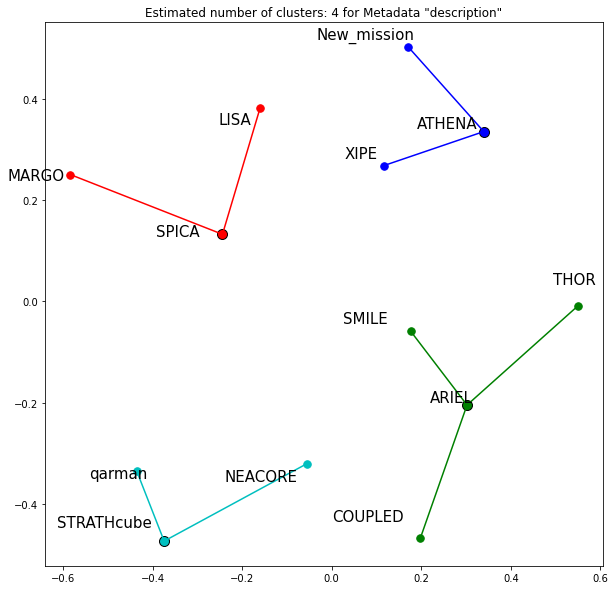

Estimated number of clusters: 4
New mission in cluster with:
ATHENA : large x-ray space observatory for identifying mechanisms behind the creation of black holes 
XIPE : This study is an X-ray polarimetry mission which aims to measure the polarization degree and angle of a large number of astronomical X-ray sources for the first time. 


,mean_sim,elements,amount_of_elements
32,0.762582,"Mirror Structure, Mirror Assembly, Mirror Assembly Mounting Structure, Mirror Assembly Module, Mirror Module 3.5 m, Mirror Module Mounting Structure, Mirror Module 4 m, Mirror Module Ring",8
3,0.767875,"MLI, MLI_Tube, MLI_ServiceModule, MLI_MM, MLI_Baffles",5
48,0.857938,"Transmitter (MOD), Transponder Transmitter, Transponder (Tx_MOD_Rx_DED), Transponder Receiver",4
12,0.839500,"RW Rockwell Collins RDR 68-3, RW Rockwell Collins RSI 12, RW Rockwell Collins WDE 8-45",3
22,0.887500,"STR Sodern Hydra Optical Head, STR Sodern Hydra Optical Head, STR Sodern Hydra Electronics Unit",3
...,...,...,...
30,0.755000,"Thruster Pair 22N, Thruster_CHT-20N",2
29,0.695000,"SVM Thermal Control Subsystem, Radiator_SVM",2
28,0.684000,"SVM Thermal Control Subsystem, Thermal Subsystem",2
27,1.000000,"Attitude, Orbit, Guidance, Navigation Control Subsystem, Attitude, Orbit, Guidance, Navigation Control Subsystem",2


,elements,mission_1,mission_2,subsystem,cosine_similarity
0,"(Attitude, Orbit, Guidance, Navigation Control Subsystem, Attitude, Orbit, Guidance, Navigation Control Subsystem)",ATHENA,XIPE,"Attitude, Orbit, Guidance, Navigation Control",1.000
1,"(Chemical Propulsion Subsystem, Chemical Propulsion Subsystem)",ATHENA,XIPE,Chemical Propulsion,1.000
2,"(Communications Subsystem, Communications Subsystem)",ATHENA,XIPE,Communications,1.000
3,"(Data-Handling Subsystem, Data-Handling Subsystem)",ATHENA,XIPE,Data-Handling,1.000
4,"(Deployable Sun Shield, Sun Shield)",ATHENA,XIPE,Mechanisms,0.764
...,...,...,...,...,...
107,"(Transponder (Tx_MOD_Rx_DED), Transponder Receiver)",ATHENA,XIPE,Communications,0.834
108,"(Transponder (Tx_MOD_Rx_DED), Transponder Transmitter)",ATHENA,XIPE,Communications,0.829
109,"(Traveling Wave Tube, Traveling Wave Tube)",ATHENA,XIPE,Communications,1.000
110,"(Venting Mechanism, Venting Mechanism)",ATHENA,XIPE,Mechanisms,1.000


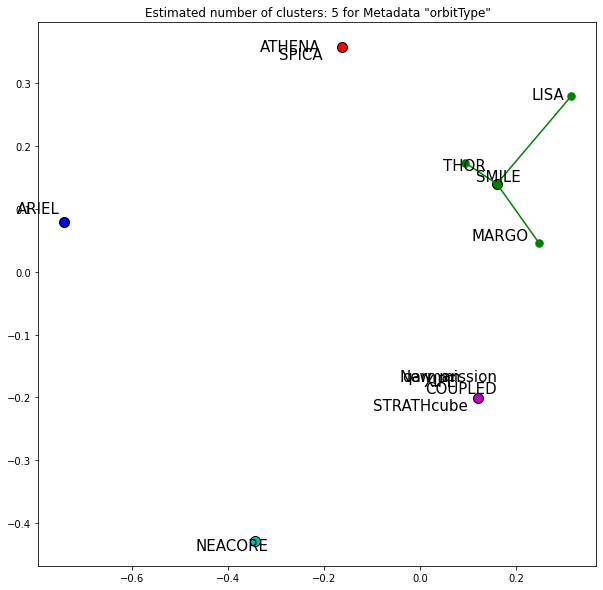

Estimated number of clusters: 5
New mission in cluster with:
COUPLED : Low earth orbit
XIPE : LEO
qarman : Low Earth Orbit
STRATHcube : Low Earth Orbit


,mean_sim,elements,amount_of_elements
2,0.773937,"SolarArray_YnegWing, SolarArray, SolarArray_Xneg, SolarArray_Xpos, SolarArray_Yneg, SolarArray_Quadpack",6
34,0.745469,"Transceiver, Transponder Receiver, Transponder Transmitter, Transceiver Receiver, Transceiver Transmitter, Radar receiver",6
50,0.748961,"Multi Layer Insulation, MLI_ServiceModule, MLI_Tube, MLI_Baffles, MLI_MM",5
1,0.838375,"Thermal Subsystem, Thermal Subsystem, Thermal Protections System Subsystem, Subsystem - Thermal Analysis",4
19,0.946000,"Power Subsystem, Power Subsystem, Subsystem - Power",3
...,...,...,...
26,1.000000,"Mechanisms Subsystem, Mechanisms Subsystem",2
25,0.624000,"Mechanisms Subsystem, Structures Subsystem",2
24,1.000000,"Space Segment, Space Segment",2
23,0.615000,"Space Segment, Launch Segment",2


,elements,mission_1,mission_2,subsystem,cosine_similarity
0,"(Attitude, Orbit, Guidance, Navigation Control Subsystem, Attitude, Orbit, Guidance, Navigation Control Subsystem)",COUPLED,XIPE,"Attitude, Orbit, Guidance, Navigation Control",1.000
1,"(Average Contact Time, Average Mission Duration)",XIPE,STRATHcube,Mission Analysis,0.616
2,"(BatteryGomBPX 2, Battery_general)",COUPLED,XIPE,Power,0.659
3,"(Chemical Propulsion Subsystem, Chemical Propulsion Subsystem)",COUPLED,XIPE,Chemical Propulsion,1.000
4,"(Chemical Propulsion Subsystem, Subsystem - Propulsion)",XIPE,STRATHcube,Chemical Propulsion,0.810
...,...,...,...,...,...
90,"(Transponder CUBATA, Transponder Transmitter)",COUPLED,XIPE,System Engineering,0.687
91,"(Transponder Receiver, Radar receiver)",XIPE,STRATHcube,Communications,0.710
92,"(Transponder for cubesat Syrlink, Transponder Receiver)",COUPLED,XIPE,Communications,0.606
93,"(Transponder for cubesat Syrlink, Transponder Transmitter)",COUPLED,XIPE,Communications,0.608


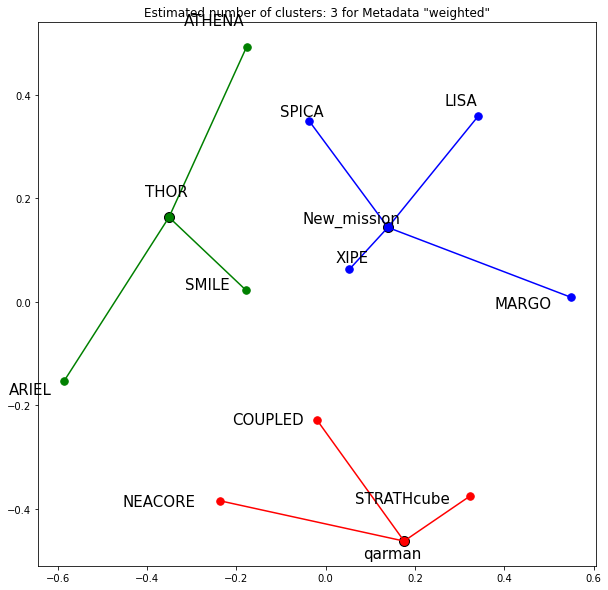

Estimated number of clusters: 3
New mission in cluster with:
LISA : 
MARGO : 
SPICA : 
XIPE : 


,mean_sim,elements,amount_of_elements
12,0.823319,"Generic Equipment EPROP, Generic Equipment AOGNC, Generic Equipment PWR, Generic Equipment DH, Generic Equipment DH2, Generic Equipment TC1, Generic Equipment Instrument, Generic Equipment TC, Generic Equipment INS, AOGNC Generic Equipment #2, AOGNC Generic Equipment, TC Generic Equipment, PWR Generic Equipment",13
53,0.781974,"Thermal Control Subsystem, Thermal Control Subsystem, TCS_Cryomodule, TCS_CoolerModule, Thermal Subsystem, Thermal Subsystem SVM, Radiator_SVM, ThermalDoubler_SVM, TCS_SVM_Extended, Thermal Subsystem CRYO, Thermal Subsystem CM",11
23,0.765617,"Propellant_DFACS_EP, Electric Propulsion Subsystem, EP Mini RIT Thruster, EP Power Processing Unit-A, EP Power Processing Unit-B, EP Flow Control System, EPS_3rdGen_Clyde_IntegratedBattery20Wh, Propellant_Transfer_EP",8
48,0.775405,"MLI, Multi Layer Insulation, Single Layer Insulation, MLI_Tube, MLI_ServiceModule, MLI_MM, MLI_Baffles",7
127,0.735031,"LP Latch Valve, Monoprop_Latch_Valve, Latch Valves, Latch_Valve_LP_Coldgas, HP Latch Valve, Low Pressure Latch Valve [Transfer]",6
...,...,...,...
115,0.614000,"Generic Equipment EPROP, TC Generic Equipment",2
114,0.641000,"Generic Equipment EPROP, AOGNC Generic Equipment",2
113,0.643000,"Generic Equipment EPROP, Generic Equipment INS",2
112,0.664000,"Generic Equipment EPROP, AOGNC Generic Equipment #2",2


,elements,mission_1,mission_2,subsystem,cosine_similarity
0,"(Antenna Deployment Mechanism, Antenna Hold Down and Release Mechanism)",LISA,MARGO,Mechanisms,0.614
1,"(Antenna Deployment Mechanism, Antenna Pointing Mechanism)",LISA,SPICA,Mechanisms,0.726
2,"(Antenna Hold Down and Release Mechanism, Antenna Pointing Mechanism)",MARGO,SPICA,Mechanisms,0.744
3,"(Antenna Pointing Mechanism with Electronics Box, Antenna Hold Down and Release Mechanism)",LISA,MARGO,Mechanisms,0.665
4,"(Antenna Pointing Mechanism with Electronics Box, Antenna Pointing Mechanism)",LISA,SPICA,Mechanisms,0.855
...,...,...,...,...,...
404,"(Traveling Wave Tube, Traveling Wave Tube)",SPICA,XIPE,Communications,1.000
405,"(X Band Transponder, Transponder)",LISA,SPICA,Communications,0.714
406,"(X Band Transponder, Transponder (Tx_MOD_Rx_DED))",LISA,XIPE,Communications,0.677
407,"(X Band Transponder, Transponder Receiver)",LISA,XIPE,Communications,0.713


In [32]:
#--------------------------------------------------------------------
## Before running make sure TypeDB server is running 
#--------------------------------------------------------------------

#--------------------------------------------------------------------
## Provide arbitary metadata input for comparison with elements in KG
#--------------------------------------------------------------------


new_mission = { 'objective': "",
                'missionObjectives': "",
                'description': 'three identical telescopes designed to measure the polarization of cosmic X-rays of black holes, neutron stars, and pulsars', 
                'background': "", 
                'plType': "",               
                'scienceObjectives':"", 
#                'requirements': "",  not implemented at the moment
                'target': "",    
                'systOfInterest': "",           
                'propType': "", 
                'lagrangePoint': "",
                'orbitType': "low earth orbit", 
                'orbitDescription': "",
                'lifetime': "3",
                'launch_date': "",
                'stwDim': "",                          
              }

#--------------------------------------------------
## Set parameters for comparison
#--------------------------------------------------
# Specify name of KG and server address (used for getting data from KG)

db_name = 'ESAEMs' ## default "ESAEMs"
server_address ='typedb:1729'  ## localhost:1729 if running jupterlab locally, else when running from docker typedb:1729 
## metadata not to inlude in detailed comparison 
exclude = {'lifetime'} ##  empty --> consider all metadata in detailed comparison, but e.g. {'lifetime'}

## settings for pandas library to display results
pd.set_option('display.max_colwidth', None)

## threshhold for element comparison, lower for more results, raise for more precise results
jaccard = 0.2 #threshhold jaccard-index
cosine = 0.6  #threshhold cosine similarity
triadic_thresh = 0.7 #threshold for triadic closures

## get past mission data from KG
labels = [metadata for metadata in new_mission.keys() if new_mission[metadata] != ""]
metadatas, sims_sort = get_data(labels, server_address)


## calculate similarities 
missions = list(metadatas.keys())
sim_new = calc_sim(new_mission,metadatas)

## initiate ExcelWriter for results
writer = ExcelWriter('results.xlsx')

## Do comparison for each metadata
for metadata in set(labels)-exclude:
        sim_values = [sim[metadata] for sim in sim_new] + [sim[metadata] for sim in sims_sort]
        clustered_missions = calculate_clusters_plot(sim_values,missions, metadata)
        compare_missions(clustered_missions, metadata, jaccard, cosine, triadic_thresh, server_address)
        
## If more than one metadata defined calculate weighted score
if len(labels)>1:
        
        highW = 0.6
        mediumW= 0.3
        lowW= 0.1
        
        ## preselected dictionary of weights for each metadata entry
        weight_dict ={ 'stwDim':lowW, 'propType':mediumW, 'orbitDescription':mediumW, 'lifetime':lowW, 'lagrangePoint':lowW, 'background':highW, 
                      'missionObjectives':highW, 'orbitType':mediumW, 'reference_documents':lowW, 'target':highW, 
                      'plType':mediumW, 'description':highW, 'objectiveCategory':lowW, 'systOfInterest':highW, 'launch_date':lowW,
                      'requirements':highW, 'scienceObjectives':highW, 'objective':highW}
        
        def weighted_avg_1(sim, weight_dict):
            
            """
            calculated weighted score for first type of similarity scores
            """
            numerator =np.sum([sim[key]*weight_dict[key] for key in sim.keys()-{'models'}])
            weighted_sim = numerator / sum([weight_dict[key] for key in sim.keys()-{'models'}])
            return {'models':sim['models'], 'sim':weighted_sim}
       
        sims_mean = [weighted_avg_1(sim,weight_dict) for sim in sims_sort]


        def weighted_avg_2(sim, weight_dict):

            """
            calculated weighted score for second type of similarity scores
            """
            
            numerator =np.sum([sim[key]*weight_dict[key] for key in sim.keys()-{'models'}])
            weighted_sim = numerator / sum([weight_dict[key] for key in sim.keys()-{'models'}])
            return weighted_sim

        sims_new_mean = [weighted_avg_2(sim,weight_dict) for sim in sim_new]

        sim_values = sims_new_mean +[sim['sim'] for sim in sims_mean]
        clustered_missions = calculate_clusters_plot(sim_values,missions,'weighted')
        compare_missions(clustered_missions, 'weighted', jaccard, cosine, triadic_thresh, server_address)

## Close Excel-file writer
writer.close()